In [1]:
import pandas as pd
from time import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline
plt.style.use('ggplot')

from features.data_provider import get_train_test_wc_dataset, get_feature_columns, get_whole_dataset

In [2]:
X_train, y_train, X_test, y_test, X_wc, y_wc = get_train_test_wc_dataset("home_win")

<Figure size 1440x432 with 0 Axes>

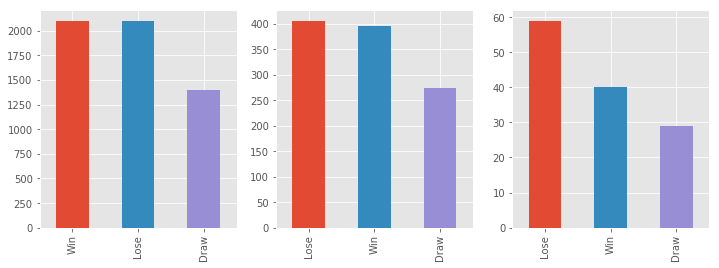

In [3]:
def get_labeled_df(s):
    df = pd.DataFrame(s)
    df[df["home_win"] == 1] = "Win"
    df[df["home_win"] == 0] = "Draw"
    df[df["home_win"] == -1] = "Lose"
    return df

plt.figure(figsize=(20, 6))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
pd.value_counts(get_labeled_df(y_train)["home_win"]).plot.bar(ax=axes[0])
pd.value_counts(get_labeled_df(y_test)["home_win"]).plot.bar(ax=axes[1])
pd.value_counts(get_labeled_df(y_wc)["home_win"]).plot.bar(ax=axes[2])

In [4]:
def get_feature_importance(clf):
    zipped = sorted(zip(get_feature_columns(), clf.feature_importances_), key = lambda t: t[1], reverse=True)
    D = {}
    for feature, importance in zipped:
        D[feature] = round(importance, 5)
        #print(f"{feature}: {importance}")
        
    plt.figure(figsize=(13, 13))
    plt.bar(range(len(D)), D.values(), align='center')
    plt.xticks(range(len(D)), list(D.keys()), rotation='vertical')
    plt.show()
        
def run_grid_search(clf, param_grid, Xtrain, ytrain, Xtest, ytest, X_wc, y_wc, custom_report_for_model=None):
    grid_search = GridSearchCV(clf, param_grid=param_grid)
    start = time()
    grid_search.fit(Xtrain, ytrain)
    print("TRAIN SET METRICS:")
    print("SCORE: ", grid_search.score(Xtrain, ytrain))
    y_true, y_pred = ytrain, grid_search.predict(Xtrain)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    print("BEST PARAMS: ", grid_search.best_params_)
    print()
    print()
    
    print("TEST SET METRICS:")
    print("SCORE: ", grid_search.score(Xtest, ytest))
    y_true, y_pred = ytest, grid_search.predict(Xtest)
    print("\n",classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
        
    print()
    print()
    print("WC SET METRICS:")
    print("SCORE: ", grid_search.score(X_wc, y_wc))
    y_true, y_pred = y_wc, grid_search.predict(X_wc)
    print("\n",classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print()
    if custom_report_for_model:
        custom_report_for_model(grid_search.best_estimator_)
    return grid_search.best_estimator_

TRAIN SET METRICS:
SCORE:  1.0
             precision    recall  f1-score   support

       -1.0       1.00      1.00      1.00      2097
        0.0       1.00      1.00      1.00      1402
        1.0       1.00      1.00      1.00      2102

avg / total       1.00      1.00      1.00      5601

[[2097    0    0]
 [   0 1402    0]
 [   0    0 2102]]
BEST PARAMS:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 500}


TEST SET METRICS:
SCORE:  0.521860465116

              precision    recall  f1-score   support

       -1.0       0.53      0.67      0.59       406
        0.0       0.31      0.08      0.12       274
        1.0       0.55      0.68      0.60       395

avg / total       0.48      0.52      0.48      1075

[[273  25 108]
 [140  21 113]
 [107  21 267]]


WC SET METRICS:
SCORE:  0.5390625

              precision    recall  f1-score   support

       -1.0       0.61      0.66      0.63        59
        0.0       0.00      0.00      0.

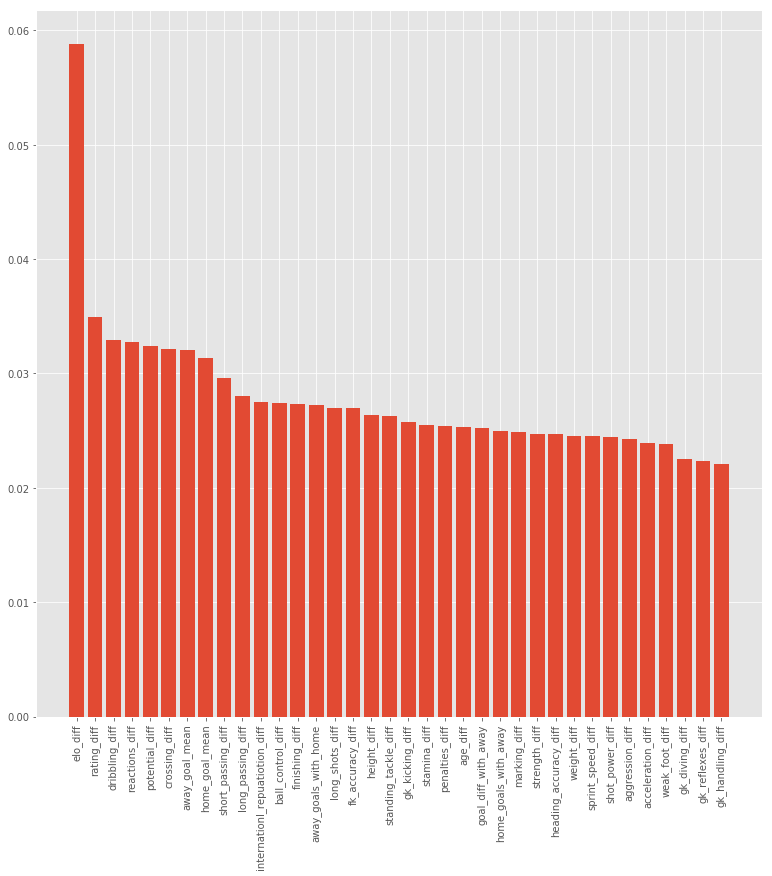

In [6]:
clf = RandomForestClassifier(oob_score=True, bootstrap=True, n_jobs=-1, class_weight={0:1.5})

param_grid = {"n_estimators": [500],
              "max_depth": [3, 5, 8, 12, None],
              "min_samples_leaf": [1, 3, 5, 10],
              "max_features": ["sqrt", "log2"]}
best_clf = run_grid_search(clf, param_grid,
                             X_train, y_train, 
                             X_test, y_test, 
                             X_wc, y_wc,
                             custom_report_for_model=get_feature_importance)

TRAIN SET METRICS:
SCORE:  1.0
             precision    recall  f1-score   support

       -1.0       1.00      1.00      1.00      2097
        0.0       1.00      1.00      1.00      1402
        1.0       1.00      1.00      1.00      2102

avg / total       1.00      1.00      1.00      5601

[[2097    0    0]
 [   0 1402    0]
 [   0    0 2102]]
BEST PARAMS:  {'n_estimators': 2000}


TEST SET METRICS:
SCORE:  0.511627906977

              precision    recall  f1-score   support

       -1.0       0.51      0.67      0.58       406
        0.0       0.21      0.04      0.07       274
        1.0       0.54      0.68      0.60       395

avg / total       0.45      0.51      0.46      1075

[[271  25 110]
 [149  12 113]
 [109  19 267]]


WC SET METRICS:
SCORE:  0.5546875

              precision    recall  f1-score   support

       -1.0       0.63      0.69      0.66        59
        0.0       0.00      0.00      0.00        29
        1.0       0.49      0.75      0.59        40

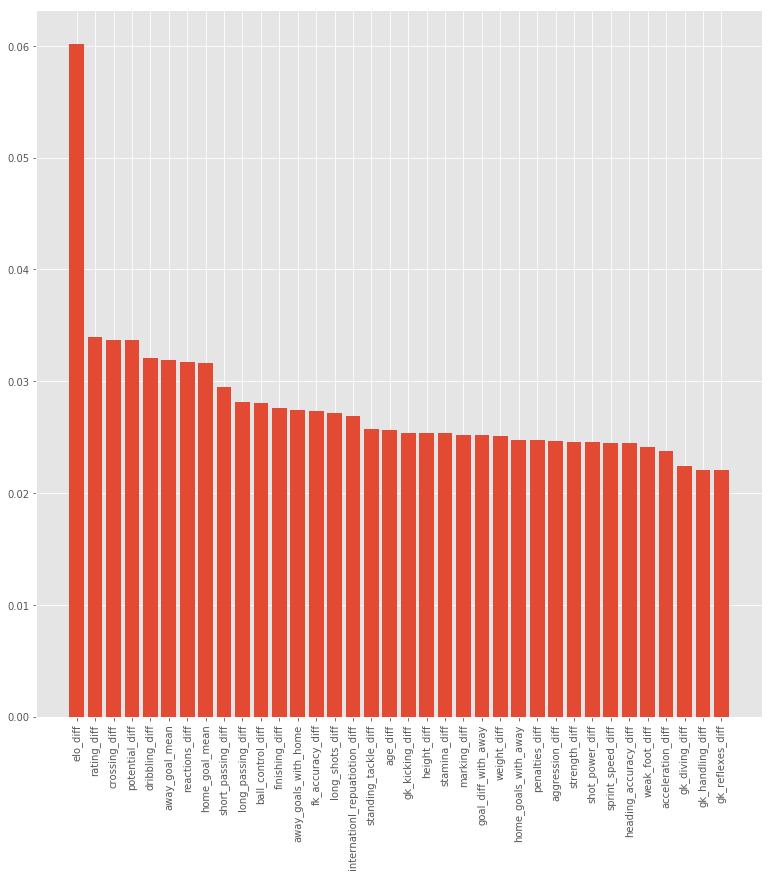

In [7]:
params = best_clf.get_params()
params.pop('n_estimators', None)
clf = RandomForestClassifier(**params)

param_grid = {"n_estimators": [200, 500, 1000, 2000, 5000]}
best_clf = run_grid_search(clf, param_grid,
                             X_train, y_train, 
                             X_test, y_test, 
                             X_wc, y_wc,
                             custom_report_for_model=get_feature_importance)